In [307]:
import random
import sys
import matplotlib.pyplot as plt
from numpy.core.numeric import NaN
import pylab
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [308]:
MISSING_VALUE = 1000000
CLUSTER_NUMBER = 4
GAMMA = 1

# preprocess data
with open('wifi_localization.txt') as f:
    file = f.readlines()
data = []
for row in file:
    data.append(([int(item) for item in row.split("\t")[:-1]],
                 int(row.split("\t")[-1].split("\n")[0])-1))
#random.shuffle(data)
points = np.array([item[0] for item in data])



In [309]:
### for testing
#points[0][0] = MISSING_VALUE
points[0][2] = MISSING_VALUE
#points[0][5] = MISSING_VALUE
#points[0][6] = MISSING_VALUE
#points[0][3] = MISSING_VALUE
#points[0][4] = MISSING_VALUE
#points[0][1] = MISSING_VALUE
#points[3][2] = MISSING_VALUE

In [310]:
def delete_specific_values_in_one_dimension(points, column, number_of_deleted_values):
    for i in range(number_of_deleted_values):
        position_of_array_deleted_in_array = random.randint(0, len(points) - 1)
        position_of_value_deleted_in_array = column
        points[position_of_array_deleted_in_array][position_of_value_deleted_in_array] = MISSING_VALUE
    return points


def delete_values_in_data(points, number_of_deleted_values):
    for i in range(number_of_deleted_values):
        position_of_array_deleted_in_array = random.randint(0, len(points) - 1)
        position_of_value_deleted_in_array = random.randint(
        0, len(points[position_of_array_deleted_in_array]) - 1)
        points[position_of_array_deleted_in_array][position_of_value_deleted_in_array] = MISSING_VALUE
    return points

def delete_random_values_in_data(points):
    number_of_deleted_values = random.randint(
    int(len(points) / 10), int(len(points) / 3))
    
    for i in range(number_of_deleted_values):
        position_of_array_deleted_in_array = random.randint(0, len(points) - 1)
        position_of_value_deleted_in_array = random.randint(
        0, len(points[position_of_array_deleted_in_array]) - 1)
        points[position_of_array_deleted_in_array][position_of_value_deleted_in_array] = MISSING_VALUE
    return points

In [311]:
# delete all data rows with incomplete data from the hole dataset
# data: numpy.array
# returns a numpy.array only with complete data rows
def split_data_in_completes(data):
    # select only rows with complete data and save it in completes
    completes = np.array(data)
    row = 0
    while row < len(completes):
        column = 0
        while column < len(completes[row]):
            if completes[row][column] == MISSING_VALUE:
                completes = np.delete(
                    completes, row, 0)
                row -= 1
            column += 1
        row += 1
    return completes


In [312]:
# delete all data rows with complete data from the hole dataset
# data: numpy.array
# returns a numpy.array only with incomplete data rows
def split_data_in_incompletes(data):
    incompletes = np.array(data)
    row = 0
    while row < len(incompletes):
        column = 0
        delete = True
        # Search for missing value
        while column < len(incompletes[row]):
            if incompletes[row][column] == MISSING_VALUE:
                delete = False
            column += 1
        # If there was a missing value found, delete the row
        if delete:
            incompletes = np.delete(
                incompletes, row, 0)
            row -= 1
        row += 1
    return incompletes

In [313]:
# calculates the means subspace of safe dimensions in a incomplete data row
# row: one row in a numpy.array
# gmm_means: all means of the gmm
# returns a numpy.array with the length of the safe dimensions and their means from the gmm
def calculate_subspace_means_safe_dimensions(row, gmm_means):
    cluster = 0
    while cluster < CLUSTER_NUMBER:
        index_unsafe_dimensions = [index for index in range(len(row)) if MISSING_VALUE == row[index]]
        subspace_means_safe_dimensions = np.delete(gmm_means[cluster],index_unsafe_dimensions, axis=0)
        cluster += 1
    return subspace_means_safe_dimensions


In [314]:
# calculates the covariances subspace of safe dimensions in a incomplete data row
# row: one row in a numpy.array
# gmm_covariances: all covariances of the gmm
# returns a numpy.array with the length of the safe dimensions and their covariances from the gmm
def calculate_subspace_covariances_safe_dimensions(row, gmm_covariances):
    cluster = 0
    while cluster < CLUSTER_NUMBER:
        index_unsafe_dimensions = [index for index in range(len(row)) if MISSING_VALUE == row[index]]
        subspace_covariances_safe_dimensions = np.delete(np.diag(gmm_covariances[cluster]), index_unsafe_dimensions, axis=1)
        subspace_covariances_safe_dimensions = np.delete(subspace_covariances_safe_dimensions, index_unsafe_dimensions, axis=0)
        cluster += 1
    return subspace_covariances_safe_dimensions


In [315]:
# calculates the means subspace of unsafe dimensions in a incomplete data row
# row: one row in a numpy.array
# gmm_means: all means of the gmm
# returns a numpy.array with the length of the unsafe dimensions and their means from the gmm
def calculate_subspace_means_unsafe_dimensions(row, gmm_means):
    cluster = 0
    while cluster < CLUSTER_NUMBER:
        index_safe_dimensions = [index for index in range(len(row)) if MISSING_VALUE != row[index]]
        # neuer Erwartungswert
        subspace_means_unsafe_dimensions = np.delete(gmm_means[cluster], index_safe_dimensions,axis=0)
        cluster += 1
    return subspace_means_unsafe_dimensions


In [316]:
# calculates the covariances subspace of unsafe dimensions in a incomplete data row
# row: one row in a numpy.array
# gmm_covariances: all covariances of the gmm
# returns a numpy.array with the length of the unsafe dimensions and their covariances from the gmm
def calculate_subspace_covariances_unsafe_dimensions(row, gmm_covariances):
    cluster = 0
    while cluster < CLUSTER_NUMBER:
        index_safe_dimensions = [index for index in range(len(row)) if MISSING_VALUE != row[index]]
        # neue Kovarianzmatrix
        subspace_covariances_unsafe_dimensions = np.delete(np.diag(gmm_covariances[cluster]), index_safe_dimensions, axis=1)
        subspace_covariances_unsafe_dimensions = np.delete(subspace_covariances_unsafe_dimensions, index_safe_dimensions, axis=0)
        cluster += 1
    return subspace_covariances_unsafe_dimensions


In [317]:
# calculates the new means for the new gmm (new_means is a list of all subspace_means_unsafe_dimensions)
# row: one row in a numpy.array
# gmm_means: all means of the gmm
# returns a list of numpy.arrays with the length of the safe dimensions and their means from the gmm
def calculate_new_means(row, gmm_means):
    cluster = 0
    new_means = np.zeros((1,np.count_nonzero(row == MISSING_VALUE)))
    while cluster < CLUSTER_NUMBER:
        index_safe_dimensions = [index for index in range(len(row)) if MISSING_VALUE != row[index]]
        # neuer Erwartungswert
        subspace_means_unsafe_dimensions = np.delete(gmm_means[cluster], index_safe_dimensions,axis=0)
        new_means = np.append(new_means, [subspace_means_unsafe_dimensions], axis=0)
        cluster += 1
    new_means = np.delete(new_means,0, axis=0)
    return new_means


In [318]:
# calculates the new covariances for the new gmm (new_covariances is a list of all subspace_covariances_unsafe_dimensions)
# row: one row in a numpy.array
# gmm_covariances: all means of the gmm
# returns a list of numpy.arrays with the length of the safe dimensions and their covariances from the gmm
def calculate_new_covariances(row, gmm_covariances):
    cluster = 0
    new_covariances = np.zeros((1,np.count_nonzero(row == MISSING_VALUE),np.count_nonzero(row == MISSING_VALUE)))
    while cluster < CLUSTER_NUMBER:
        index_safe_dimensions = [index for index in range(len(row)) if MISSING_VALUE != row[index]]
        # neue Kovarianzmatrix
        subspace_covariances_unsafe_dimensions = np.delete(np.diag(gmm_covariances[cluster]), index_safe_dimensions, axis=1)
        subspace_covariances_unsafe_dimensions = np.delete(subspace_covariances_unsafe_dimensions, index_safe_dimensions, axis=0)
        new_covariances = np.append(new_covariances, [subspace_covariances_unsafe_dimensions], axis=0)
        cluster += 1
    new_covariances = np.delete(new_covariances,0, axis=0)
    return new_covariances


In [319]:
# get the values of the safe dimensions
# row: one row in a numpy.array
# returns numpy.array with all safe dimensions
def get_safe_dimensions(row):
    cluster = 0
    while cluster < CLUSTER_NUMBER:
        safe_dimensions = [value for value in row if MISSING_VALUE != value]
        safe_dimensions = np.array(safe_dimensions)
        cluster += 1
    return safe_dimensions


In [320]:
# calculate c of a row with gamma
# row: one row in a numpy.array
# gmm_means: means of the gmm
# covariances: covariances of the gmm
# returns a list of all c's (for example if the gmm contains five clusters the array contains five values) 
def calculate_c_with_gamma(row, gmm_means, gmm_covariances):
    cluster = 0
    c_list_gamma = np.zeros([CLUSTER_NUMBER])
    while cluster < CLUSTER_NUMBER:
        safe_dimensions = [value for value in row if MISSING_VALUE != value]
        safe_dimensions = np.array(safe_dimensions)

        index_unsafe_dimensions = [index for index in range(len(row)) if MISSING_VALUE == row[index]]
        subspace_means_safe_dimensions = np.delete(gmm_means[cluster],index_unsafe_dimensions, axis=0)

        index_unsafe_dimensions = [index for index in range(len(row)) if MISSING_VALUE == row[index]]
        subspace_covariances_safe_dimensions = np.delete(np.diag(gmm_covariances[cluster]), index_unsafe_dimensions, axis=1)
        subspace_covariances_safe_dimensions = np.delete(subspace_covariances_safe_dimensions, index_unsafe_dimensions, axis=0)
        gamma_matrix = np.zeros((len(safe_dimensions),len(safe_dimensions)))
        i = 0
        while i < len(safe_dimensions):
            gamma_matrix[i][i] = GAMMA
            i+= 1
        subspace_covariances_safe_dimensions_with_gamma = gamma_matrix + subspace_covariances_safe_dimensions
        #print(subspace_covariances_safe_dimensions)
        #print(gamma_matrix)
        #print(subspace_covariances_safe_dimensions_with_gamma)
        c_i_gamma = multivariate_normal.pdf(safe_dimensions, mean=subspace_means_safe_dimensions, cov=subspace_covariances_safe_dimensions_with_gamma)
        c_list_gamma = np.append(c_list_gamma,c_i_gamma)
        cluster += 1
    c_list_gamma = c_list_gamma[c_list_gamma != 0]
    return c_list_gamma


In [321]:
# calculate c of a row
# row: one row in a numpy.array
# gmm_means: means of the gmm
# covariances: covariances of the gmm
# returns a list of all c's (for example if the gmm contains five clusters the array contains five values) 
def calculate_c(row, gmm_means, gmm_covariances):
    cluster = 0
    c_list = np.zeros([CLUSTER_NUMBER])
    while cluster < CLUSTER_NUMBER:
        safe_dimensions = [value for value in row if MISSING_VALUE != value]
        safe_dimensions = np.array(safe_dimensions)

        index_unsafe_dimensions = [index for index in range(len(row)) if MISSING_VALUE == row[index]]
        subspace_means_safe_dimensions = np.delete(gmm_means[cluster],index_unsafe_dimensions, axis=0)

        index_unsafe_dimensions = [index for index in range(len(row)) if MISSING_VALUE == row[index]]
        subspace_covariances_safe_dimensions = np.delete(np.diag(gmm_covariances[cluster]), index_unsafe_dimensions, axis=1)
        subspace_covariances_safe_dimensions = np.delete(subspace_covariances_safe_dimensions, index_unsafe_dimensions, axis=0)
    
        c_i = multivariate_normal.pdf(safe_dimensions, mean=subspace_means_safe_dimensions, cov=subspace_covariances_safe_dimensions)
        c_list = np.append(c_list,c_i)
        cluster += 1
    c_list = c_list[c_list != 0]
    return c_list

In [322]:
# calculate the new weights for the gmm (r in the paper)
# c_list_gamma: is a list with all c's (c in the paper)
# gmm_weights: weights of the gmm
# returns new weights for the gmm as numpy.array
def calculate_new_weights_gamma(c_list_gamma, gmm_weights):
    multiplicated_list = [c_list_gamma*gmm_weights for c_list_gamma,gmm_weights in zip(c_list_gamma,gmm_weights)]
    sum_multiplicated_list = sum(multiplicated_list)

    # normalize known dimensions
    cluster = 0
    new_weights_gamma = np.zeros([CLUSTER_NUMBER])

    while cluster < CLUSTER_NUMBER:
        r_i = ((c_list_gamma[cluster]*gmm_weights[cluster]) / sum_multiplicated_list)
        new_weights_gamma = np.append(new_weights_gamma,r_i)
        cluster += 1
    # neue Gewichte
    new_weights_gamma = new_weights_gamma[new_weights_gamma != 0]
    return new_weights_gamma


In [323]:
# calculate the new weights for the gmm (r in the paper)
# c_list: is a list with all c's (c in the paper)
# gmm_weights: weights of the gmm
# returns new weights for the gmm as numpy.array
def calculate_new_weights(c_list, gmm_weights):
    multiplicated_list = [c_list*gmm_weights for c_list,gmm_weights in zip(c_list,gmm_weights)]
    sum_multiplicated_list = sum(multiplicated_list)

    # normalize known dimensions
    cluster = 0
    new_weights = np.zeros([CLUSTER_NUMBER])

    while cluster < CLUSTER_NUMBER:
        r_i = ((c_list[cluster]*gmm_weights[cluster]) / sum_multiplicated_list)
        new_weights = np.append(new_weights,r_i)
        cluster += 1
    # neue Gewichte
    new_weights = new_weights[new_weights != 0]
    return new_weights

In [324]:
### TEST
# this is for testing the method with data for the unsafe dimensions (when x1,x3,x5 is known; y is x2,x4,x6,x7)
# unsafe_dimensions: an numpy.array (y)
# returns the density for all clusters as numpy.array
def y_in_new_gmm(unsafe_dimensions,gmm_means,gmm_covariances, row, new_weights):
    cluster = 0
    new_normal_distribution_list = np.zeros([CLUSTER_NUMBER])
    density_values = np.zeros([CLUSTER_NUMBER])
    while cluster < CLUSTER_NUMBER:
        index_safe_dimensions = [index for index in range(len(row)) if MISSING_VALUE != row[index]]
        subspace_means_unsafe_dimensions = np.delete(gmm_means[cluster], index_safe_dimensions,axis=0)

        index_safe_dimensions = [index for index in range(len(row)) if MISSING_VALUE != row[index]]
        subspace_covariances_unsafe_dimensions = np.delete(np.diag(gmm_covariances[cluster]), index_safe_dimensions, axis=1)
        subspace_covariances_unsafe_dimensions = np.delete(subspace_covariances_unsafe_dimensions, index_safe_dimensions, axis=0)

        new_normal_distribution = multivariate_normal.pdf(unsafe_dimensions, mean=subspace_means_unsafe_dimensions, cov=subspace_covariances_unsafe_dimensions)
        new_normal_distribution_list = np.append(new_normal_distribution_list, new_normal_distribution)

        cluster += 1
    
    new_normal_distribution_list = new_normal_distribution_list[new_normal_distribution_list != 0]
    r_and_new_value = [new_weights*new_normal_distribution_list for new_weights,new_normal_distribution_list in zip(new_weights,new_normal_distribution_list)]
    sum_values = sum(r_and_new_value)
    
    i = 0
    while i < CLUSTER_NUMBER:
        normalized_new_normal_distribution = ((r_and_new_value[i]) / sum_values)
        density_values = np.append(density_values,normalized_new_normal_distribution)
        i += 1
    density_values = density_values[density_values != 0]
    print(density_values)
    return density_values


In [325]:
# main function
# points: numpy.array with missing_values
# returns a list of tupels which has the length of all incomplete data rows (when points has 25 rows with missing values the list of the tupels has the length of 25)
# one tupel contains the new weights, new covariances and new means for the missing dimensions
def gmm_distribution_missing_values(points):
    means_covariances_weights_list = []
    means_covariances_weights_list_gamma = []

    # delete random values 
    #points = delete_random_values_in_data(points)

    # delete a certain number of values
    #points = delete_values_in_data(points, 100)

    # delete values in one dimension
    #points = delete_specific_values_in_one_dimension(points, 2, 500)

    completes = split_data_in_completes(points)

    gmm = GaussianMixture(covariance_type="diag", n_components=CLUSTER_NUMBER).fit(
        completes)
    gmm_means = np.array(gmm.means_)
    gmm_covariances = np.array(gmm.covariances_)
    gmm_weights = np.array(gmm.weights_)
    labels = gmm.predict(completes)
    
    visualization_of_gmm_pca(labels, completes, gmm_means)
    #print(gmm_means)
    #print(gmm_covariances)
    #print(gmm_weights)
    ### TEST
    probabilites = gmm.predict_proba([[-64,-56,-61,-66,-71,-82,-81]])
    #print("Verteilungen mit vollständigem Wert durch GMM predicted (-64,-56,-61,-66,-71,-82,-81): ",probabilites)
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Prediction with complete values')
    ax.set_ylabel('Density')
    ax.set_xlabel('Cluster')
    langs = list(range(1,CLUSTER_NUMBER + 1))
    propabilities_list = probabilites.tolist()
    propabilities_rounded = [round(num,6) for num in propabilities_list[0]]
    #propabilities
    pred_bar_chart = ax.bar(langs,propabilities_rounded)
    ax.bar_label(pred_bar_chart, label_type='edge')
    plt.show()

    incompletes = split_data_in_incompletes(points)

    for row in incompletes:
        subspace_means_safe_dimensions = calculate_subspace_means_safe_dimensions(row, gmm_means)
        subspace_covariances_safe_dimensions = calculate_subspace_covariances_safe_dimensions(row, gmm_covariances)
        subspace_means_unsafe_dimensions = calculate_subspace_means_unsafe_dimensions(row, gmm_means)
        subspace_covariances_unsafe_dimensions = calculate_subspace_covariances_unsafe_dimensions(row, gmm_covariances)
        new_means = calculate_new_means(row, gmm_means)
        new_covariances = calculate_new_covariances(row, gmm_covariances)
        safe_dimensions = get_safe_dimensions(row)
        c_list_gamma = calculate_c_with_gamma(row, gmm_means, gmm_covariances)
        c_list = calculate_c(row, gmm_means, gmm_covariances)
        new_weights_gamma = calculate_new_weights_gamma(c_list_gamma,gmm_weights)
        new_weights = calculate_new_weights(c_list,gmm_weights)
        means_covariances_weights_one_row = new_means, new_covariances, new_weights
        means_covariances_weights_list.append(means_covariances_weights_one_row)
        means_covariances_weights_one_row_gamma = new_means, new_covariances, new_weights_gamma
        means_covariances_weights_list_gamma.append(means_covariances_weights_one_row_gamma)

        visualize_probability_function(new_means, new_covariances)

    ### TEST
    #new_normal_distribution_list = y_in_new_gmm([-64], gmm_means, gmm_covariances, row, new_weights)
    #print("Geschätzte Werte: " ,new_normal_distribution_list)
    return means_covariances_weights_list,means_covariances_weights_list_gamma


In [326]:
def visualize_probability_function(new_means, new_covariances):
    #print(new_means)
    #print("Kovarianten: ", new_covariances)
    mu_1 = new_means[0][0]
    srd_1 = new_covariances[0][0][0]

    mu_2 = new_means[1][0]
    srd_2 = new_covariances[1][0][0]

    mu_3 = new_means[2][0]
    srd_3 = new_covariances[2][0][0]

    mu_4 = new_means[3][0]
    srd_4 = new_covariances[3][0][0]

    new_data = np.random.randn(50000)
    data_1 = new_data * srd_1 + mu_1

    new_data = np.random.randn(50000)
    data_2 = new_data * srd_2 + mu_2

    new_data = np.random.randn(50000)
    data_3 = new_data * srd_3 + mu_3

    new_data = np.random.randn(50000)
    data_4 = new_data * srd_4 + mu_4

    new_data = np.concatenate((data_1, data_2, data_3, data_4), axis=0)

    new_data = new_data.reshape(-1, 1)
    
    hx, hy, _ = plt.hist(new_data, bins=100, density=1,color="lightblue")

    plt.title('New gaussian mixture model with one missing dimension')
    plt.grid()
    plt.show()

In [327]:
#def new_gmm():
    #new_gmm = GaussianMixture(covariance_type="diag", n_)

In [328]:
    def visualization_of_gmm_pca(labels, completes, gmm_means):
        pca = PCA(n_components=2)
        pca.fit(gmm_means)
        points_transformed = pca.transform(completes).tolist()
        means_transformed = pca.transform(gmm_means).tolist()

        fig = plt.figure()
        ax = fig.add_subplot()
    
        ax.set_title('Visualization the the initial GMM')
        ax.scatter([item[0] for item in points_transformed], [item[1] for item in points_transformed], c=labels)
        ax.scatter([item[0] for item in means_transformed], [item[1] for item in means_transformed],c="red")

        pylab.show()    

83414.36054108957


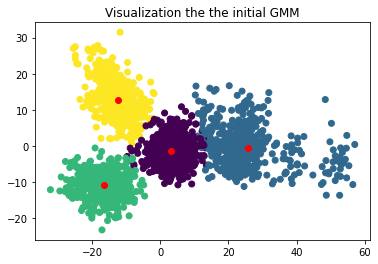

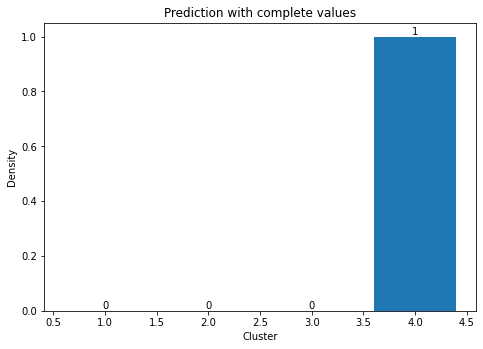

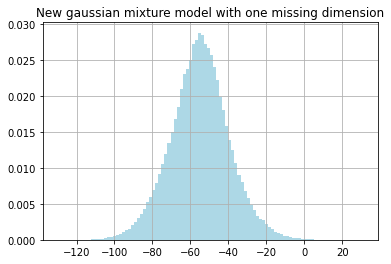

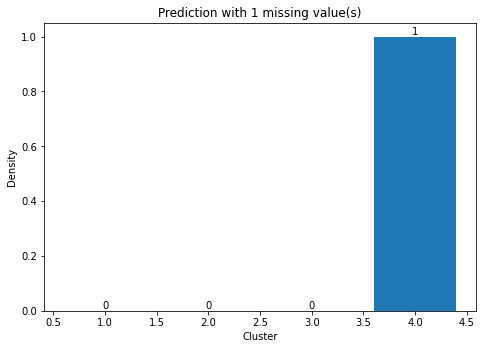

In [329]:
list_with_all_new_values = gmm_distribution_missing_values(points)
#print(list_with_all_new_values[0])
incompletes = split_data_in_incompletes(points)
number_of_missing_values = np.count_nonzero(incompletes == MISSING_VALUE)
number_of_missing_values_str = str(number_of_missing_values)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Prediction with ' + number_of_missing_values_str + ' missing value(s)')
ax.set_ylabel('Density')
ax.set_xlabel('Cluster')
langs = list(range(1,CLUSTER_NUMBER + 1))
propabilities = list_with_all_new_values[0][0][2]
propabilities_rounded = [round(num,6) for num in propabilities]
#print(propabilities)
pred_bar_chart = ax.bar(langs,propabilities_rounded)
ax.bar_label(pred_bar_chart, label_type='edge')
plt.show()

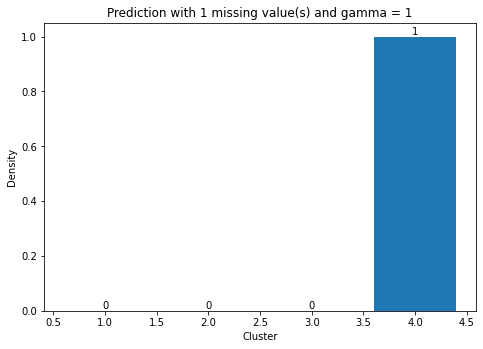

In [330]:
#print(list_with_all_new_values[1])
incompletes = split_data_in_incompletes(points)
number_of_missing_values = np.count_nonzero(incompletes == MISSING_VALUE)
number_of_missing_values_str = str(number_of_missing_values)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Prediction with ' + number_of_missing_values_str + ' missing value(s) and gamma = 1')
ax.set_ylabel('Density')
ax.set_xlabel('Cluster')
langs = list(range(1,CLUSTER_NUMBER + 1))
propabilities = list_with_all_new_values[1][0][2]
propabilities_rounded = [round(num,6) for num in propabilities]
#print(propabilities)
pred_bar_chart = ax.bar(langs,propabilities_rounded)
ax.bar_label(pred_bar_chart, label_type='edge')
plt.show()

In [331]:
#completes = split_data_in_completes(points)
#completes
#new_gmm = GaussianMixture(n_components = 10,covariance_type = 'diag',weights_init=list_with_all_new_values[0][2],means_init=[0][0]).fit(completes)
#new_gmm.predict_proba([[-64,-61]])
#new_gmm_means = np.array(new_gmm.means_)
#new_gmm_covariances = np.array(new_gmm.covariances_)
#new_gmm_weights = np.array(new_gmm.weights_)